In [2]:
import os

# Set the CUDA_VISIBLE_DEVICES environment variable
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Replace with the GPU index you want to use

# Confirm the selected GPU
print(f"Using GPU {os.environ['CUDA_VISIBLE_DEVICES']} for the experiment.")

Using GPU 3 for the experiment.


In [3]:
#imports
import matplotlib.pyplot as plt
import h5py
import numpy as np
import scipy
import seaborn as sns
import math
import json
import tensorflow as tf
import keras as keras
from keras.layers import Input, LSTM, RepeatVector, Dense
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

2024-04-29 14:45:27.481331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Set hyperparameters for this experiment
pat_val = 50
units = 256
optim = 'adam'
opt_short = 'A'
runn = 3

#set save_path
save_path = "./Saved_Models_Data/P"+str(pat_val)+"_U"+str(units)+"O"+opt_short+"/"
print("Saving to: ",save_path)

#Create the necessary directory to save to:
if not os.path.exists(save_path):
    os.mkdir(save_path)
    print("Folder Created!")
else:
    print("Folder Already Exists!")

Saving to:  ./Saved_Models_Data/P50_U256OA/
Folder Already Exists!


In [5]:
#Prepare Training Data:
path_to_X = "../Normalised/X.npy"
path_to_Y = "../Normalised/Y.npy"
X = np.load(path_to_X)
Y = np.load(path_to_Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
print(len(X_train))
print(len(X_test))
# Reshape the input and output data for the encoder and decoder
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # (No of Data, 50) to (No of data, 50,1)
print("X_train_reshaped shape: ", X_train_reshaped.shape)
Y_train_reshaped = Y_train.reshape(Y_train.shape[0], Y_train.shape[1], 1)
print("Y_train_resahped shape: ", Y_train_reshaped.shape)
# Define the input shape for the encoder
input_shape = X_train_reshaped.shape[1:]  # Shape: (sequence_length, 1) # 50,1
print("Input_shape: ", input_shape)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
Y_test_reshaped = Y_test.reshape(Y_test.shape[0], Y_test.shape[1], 1)
print("X_test_reshaped",X_test_reshaped.shape)
print("Y_test_reshaped",Y_test_reshaped.shape)

49730
12433
X_train_reshaped shape:  (49730, 50, 1)
Y_train_resahped shape:  (49730, 81, 1)
Input_shape:  (50, 1)
X_test_reshaped (12433, 50, 1)
Y_test_reshaped (12433, 81, 1)


In [6]:
# Define the model
def createModel(units, optimizer):        
    # Define the encoder
    encoder_inputs = Input(shape=input_shape)
    encoder_lstm = LSTM(units)(encoder_inputs)
    encoder_model = Model(encoder_inputs, encoder_lstm)
    
    # Define the input shape for the decoder (with units to match encoder LSTM units)
    decoder_inputs = Input(shape=(units,))  # This will serve as the initial state of the decoder LSTM
    decoder_lstm = LSTM(units, return_sequences=True)(RepeatVector(Y_train_reshaped.shape[1])(decoder_inputs))
    decoder_outputs = Dense(1, activation='sigmoid')(decoder_lstm)
    
    # Define the decoder model
    decoder_model = Model(decoder_inputs, decoder_outputs)
    
    # Create the full seq_model model
    seq_model_outputs = decoder_model(encoder_lstm)
    seq_model = Model(encoder_inputs, seq_model_outputs)
    
    # Compile the model
    seq_model.compile(optimizer=optimizer, loss='mean_squared_error', metrics = ['mae'])
    
    # Display the model summary
    seq_model.summary()
    return seq_model

In [7]:
#Train the model
# Enable logging of device placement
tf.debugging.set_log_device_placement(False)

# Verify the available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs:", gpus)
if gpus:
    # Use the first GPU for training
    with tf.device('/GPU:3'):
        seq_model = createModel(units,optim)
        early_stopping = EarlyStopping(monitor='val_loss', patience=pat_val, verbose=1)
        mc = ModelCheckpoint(save_path+"best_enc_dec_"+str(runn)+".h5", monitor = 'val_loss',mode='min', save_best_only=True, verbose=1)
        history = seq_model.fit(X_train_reshaped, Y_train_reshaped, batch_size=32, epochs=200, validation_split=0.2, callbacks=[early_stopping, mc])
        with open(save_path+'history_'+str(runn)+'.json','w') as file:
            json.dump(history.history, file)
else:
    print("No GPU available.")

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-29 14:45:53.882598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78946 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:e1:00.0, compute capability: 8.0


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 model_1 (Functional)        (None, 81, 1)             525569    
                                                                 
Total params: 789761 (3.01 MB)
Trainable params: 789761 (3.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200


2024-04-29 14:45:58.345786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-29 14:45:58.485434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-29 14:45:58.486011: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb7d8096c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-29 14:45:58.486041: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-29 14:45:58.492031: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-29 14:45:58.607932: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1242/1244 [============================>.] - ETA: 0s - loss: 0.1142 - mae: 0.2265
Epoch 1: val_loss improved from inf to 0.11125, saving model to ./Saved_Models_Data/P50_U256OA/best_enc_dec_3.h5
1244/1244 [==============================] - 21s 14ms/step - loss: 0.1142 - mae: 0.2265 - val_loss: 0.1113 - val_mae: 0.2312
Epoch 2/200
  10/1244 [..............................] - ETA: 15s - loss: 0.1103 - mae: 0.2287

/usr/local/lib/python3.8/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1241/1244 [============================>.] - ETA: 0s - loss: 0.0928 - mae: 0.1864
Epoch 2: val_loss improved from 0.11125 to 0.07614, saving model to ./Saved_Models_Data/P50_U256OA/best_enc_dec_3.h5
1244/1244 [==============================] - 17s 14ms/step - loss: 0.0928 - mae: 0.1863 - val_loss: 0.0761 - val_mae: 0.1563
Epoch 3/200
1240/1244 [============================>.] - ETA: 0s - loss: 0.0835 - mae: 0.1634
Epoch 3: val_loss did not improve from 0.07614
1244/1244 [==============================] - 17s 14ms/step - loss: 0.0835 - mae: 0.1635 - val_loss: 0.1050 - val_mae: 0.2073
Epoch 4/200
1241/1244 [============================>.] - ETA: 0s - loss: 0.1022 - mae: 0.1992
Epoch 4: val_loss did not improve from 0.07614
1244/1244 [==============================] - 17s 14ms/step - loss: 0.1022 - mae: 0.1991 - val_loss: 0.0951 - val_mae: 0.1911
Epoch 5/200
1244/1244 [==============================] - ETA: 0s - loss: 0.1068 - mae: 0.2080
Epoch 5: val_loss did not improve from 0.07614
124

In [8]:
import numpy as np
import json
import matplotlib.pyplot as plt

f = open(save_path+"history_"+str(runn)+".json")
history = json.load(f)
print(len(history['loss']))

173


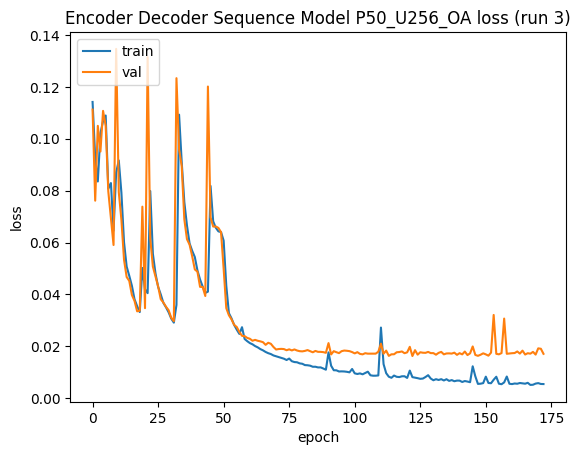

In [9]:
# summarize history for loss
mod_name = "P"+str(pat_val)+"_U"+str(units)+"_O"+opt_short
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Encoder Decoder Sequence Model '+mod_name+' loss (run '+str(runn)+')')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [10]:
#Evaluate the saved best model:
from keras.models import load_model
saved_model = load_model(save_path+"best_enc_dec_"+str(runn)+".h5")
best_eval = saved_model.evaluate(X_test_reshaped, Y_test_reshaped)

print("Mean Squared Error: ", best_eval[0])
print("Mean Absolute Error: ", best_eval[1])

#RMSE:
mse_value = best_eval[0]
rmse_value = np.sqrt(mse_value)
print("Root Mean Squared Error (RMSE): ", rmse_value)

389/389 [==============================] - 3s 6ms/step - loss: 0.0164 - mae: 0.0250
Mean Squared Error:  0.01640755496919155
Mean Absolute Error:  0.025014646351337433
Root Mean Squared Error (RMSE):  0.12809197855131893


In [11]:
#Save the predictions
predictions = saved_model.predict(X_test_reshaped)
original_shape_predictions = predictions.reshape(X_test.shape[0], Y_test.shape[1])
np.save(save_path+"predictions_"+str(runn)+".npy",original_shape_predictions)

#Save the ground truth:
np.save(save_path+"ground-truth_"+str(runn)+".npy", Y_test)

389/389 [==============================] - 3s 5ms/step


In [12]:
y_pred = np.load(save_path+"predictions_"+str(runn)+".npy")
y_true = np.load(save_path +"ground-truth_"+str(runn)+".npy")

print(y_pred.shape)
print(y_true.shape)
#Print some samples:
for sample in range(5):
    print(f"SAMPLE: {sample}")
    for i in range (81):
        print(f"Index {i} Ground truth: {y_true[sample][i]} Predicted: {y_pred[sample][i]}")

(12433, 81)
(12433, 81)
SAMPLE: 0
Index 0 Ground truth: 0 Predicted: 0.00019734790839720517
Index 1 Ground truth: 0 Predicted: 0.16278210282325745
Index 2 Ground truth: 1 Predicted: 0.7900128960609436
Index 3 Ground truth: 0 Predicted: 0.00019331509247422218
Index 4 Ground truth: 0 Predicted: 1.345442342426395e-06
Index 5 Ground truth: 0 Predicted: 5.317075647326419e-06
Index 6 Ground truth: 0 Predicted: 8.811815064291295e-07
Index 7 Ground truth: 0 Predicted: 8.485720172757283e-06
Index 8 Ground truth: 0 Predicted: 0.0001389786775689572
Index 9 Ground truth: 0 Predicted: 7.002612255746499e-05
Index 10 Ground truth: 0 Predicted: 1.977554546783722e-07
Index 11 Ground truth: 0 Predicted: 3.721423490787856e-05
Index 12 Ground truth: 0 Predicted: 0.00011057564552174881
Index 13 Ground truth: 1 Predicted: 0.9997047781944275
Index 14 Ground truth: 0 Predicted: 9.248177957488224e-05
Index 15 Ground truth: 0 Predicted: 3.0904589948477224e-05
Index 16 Ground truth: 0 Predicted: 0.00013807859795

In [13]:
#Can convert to Benesh version for predictions using a threshold here (0.5)
print("Converting the predictions to benesh versions:")
benesh_arr = np.zeros_like(y_pred)

for sample in range(len(y_pred)):
  #print(f"SAMPLE: {sample}")
  for i in range (81):
    # can add more logic here to change the thresholds for specific indices.
    if y_pred[sample][i] >= 0.5:
      benesh_arr[sample][i] = 1
    elif y_pred[sample][i] < 0.5:
      benesh_arr[sample][i]= 0

print(benesh_arr[:2])
np.save(save_path+"y_pred_benesh_"+str(runn)+".npy", benesh_arr)

Converting the predictions to benesh versions:
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 1. 0. 0. 1. 0. 0. 0.]]


In [14]:
y_pred = np.load(save_path+"predictions_"+str(runn)+".npy")
y_true = np.load(save_path+"ground-truth_"+str(runn)+".npy")

err_arr = np.zeros((12433,81))

for r in range(len(y_pred)):
    for c in range(81):
        err_arr[r][c] = abs(y_true[r][c]-y_pred[r][c])
        
np.save(save_path+"err_arr_"+str(runn)+".npy",err_arr)

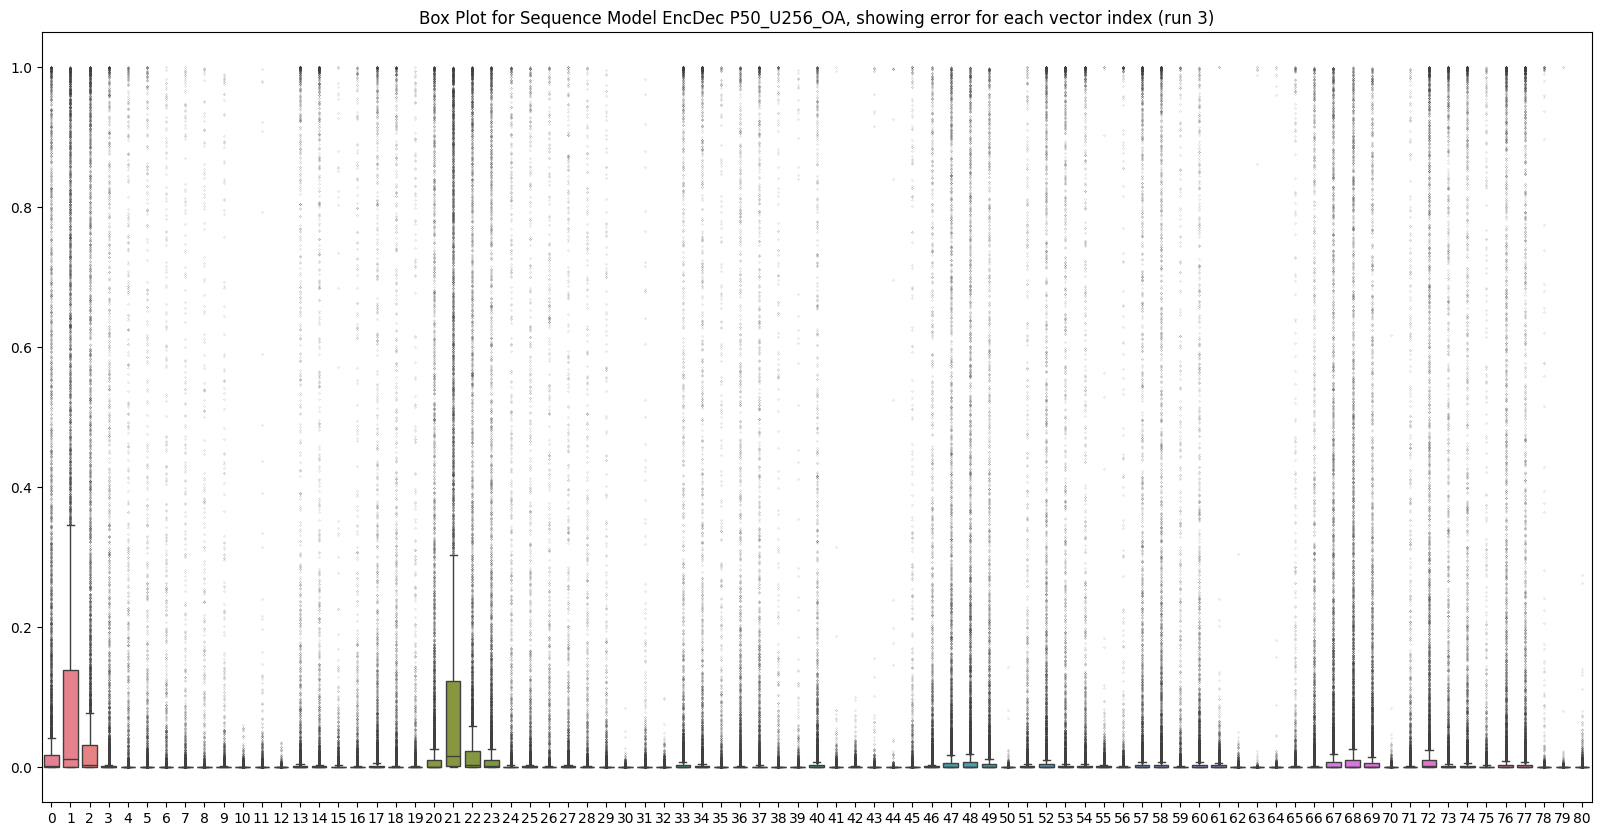

In [15]:
import seaborn as sns
err_arr = np.load(save_path+"err_arr_"+str(runn)+".npy")
#fig, ax = plt.subplots(figsize=(18, 9))
plt.figure(figsize = (20,10))
sns.boxplot(err_arr, fliersize = 0.1 ,gap=0.05).set(title='Box Plot for Sequence Model EncDec '+mod_name+', showing error for each vector index (run '+str(runn)+')')
plt.show()

In [16]:
def mean_abs_perc_err(gt_arr, pred_arr, num_samples, vec_size):
    global overall_MAPE
    err_arr = np.zeros((num_samples,vec_size))
    print("Calculating MAPE")
    for r in range(len(pred_arr)):
        for c in range(vec_size):
          err_arr[r][c] = abs(gt_arr[r][c]-pred_arr[r][c]) # Calculation of the percentage error
    per_sample_mape_arr = np.sum(err_arr,axis=1)/vec_size
    print(per_sample_mape_arr.shape)
    print("MAPE for 10 samples...",per_sample_mape_arr[:10])
    overall_MAPE = sum(per_sample_mape_arr)/num_samples*100 # Multiply by 100 to get the percentage
    print("OVERALL MAPE: ", overall_MAPE)

n_samples = 12433
v_size = 81
y_pred = np.load(save_path+"predictions_"+str(runn)+".npy")
y_true = np.load(save_path+"ground-truth_"+str(runn)+".npy")
mean_abs_perc_err(y_true,y_pred,n_samples,v_size)

Calculating MAPE
(12433,)
MAPE for 10 samples... [0.01577423 0.00579824 0.00394777 0.00656152 0.01220696 0.01596434
 0.03759898 0.08485491 0.0029689  0.02090521]
OVERALL MAPE:  2.5014644497171488


In [17]:
from sklearn.metrics import r2_score

In [18]:
y_pred = np.load(save_path+"predictions_"+str(runn)+".npy")
y_true = np.load(save_path+"ground-truth_"+str(runn)+".npy")

In [19]:
#Calculate R2 Score:
result_r2 = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the R-squared value for each row
    r2 = r2_score(y_true[i, :], y_pred[i, :])
    result_r2[i] = r2

print("R-squared value for each row (sample):", result_r2)
# Calculate the overall R-squared value
overall_r2 = np.mean(result_r2)

# Print the overall R-squared value
print("Overall R-squared value:", overall_r2)

R-squared value for each row (sample): [0.96084884 0.9957578  0.99806905 ... 0.8749606  0.96038334 0.98581916]
Overall R-squared value: 0.869987977587253


In [20]:
#Spearman Correlation:
result = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Spearman correlation for each row
    row_result = scipy.stats.spearmanr(y_true[i, :], y_pred[i, :])

    # Checking for zero standard deviation
    if np.isnan(row_result.correlation) or np.isnan(row_result.pvalue):
        # Handle the case where the result contains NaN
        result[i] = 0  # Set the correlation coefficient to 0
    else:
        result[i] = row_result.correlation

print("Spearman correlation coefficients for each row (sample):", result)
overall_spearman_corr = np.mean(result)

# Print the overall Spearman correlation coefficient
print("Overall Spearman correlation coefficient:", overall_spearman_corr)

Spearman correlation coefficients for each row (sample): [0.61535237 0.61535237 0.61535237 ... 0.60792058 0.61535237 0.61535237]
Overall Spearman correlation coefficient: 0.6050454215501536


In [21]:
#Pearson Correlation:
result_pearson = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Pearson correlation for each row
    corr_matrix = np.corrcoef(y_true[i, :], y_pred[i, :])
    result_pearson[i] = corr_matrix[0, 1]

# Calculate the overall Pearson correlation coefficient
overall_pearson_corr = np.mean(result_pearson)

print("Pearson correlation coefficients for each row:", result_pearson)
print(len(result_pearson))
# Print the overall Pearson correlation coefficient
print("Overall Pearson correlation coefficient:", overall_pearson_corr)

Pearson correlation coefficients for each row: [0.98048207 0.9980048  0.99911874 ... 0.93561626 0.98026847 0.99322073]
12433
Overall Pearson correlation coefficient: 0.9321496970045328


In [22]:
from sklearn.metrics import matthews_corrcoef #calculated using the converted 0.5 threshold benesh vector
y_pred = np.load(save_path + "y_pred_benesh_"+str(runn)+".npy")
y_true = np.load(save_path + "ground-truth_"+str(runn)+".npy")

result_mcc = np.zeros(y_true.shape[0])

for i in range(y_true.shape[0]):
    # Calculate the Matthews Correlation Coefficient for each row
    mcc = matthews_corrcoef(y_true[i, :], y_pred[i, :])
    result_mcc[i] = mcc

# Calculate the overall Matthews Correlation Coefficient
overall_mcc = np.mean(result_mcc)

# Print the overall Matthews Correlation Coefficient
print("Overall Matthews Correlation Coefficient:", overall_mcc)

Overall Matthews Correlation Coefficient: 0.9182099447313775


In [23]:
#Save boxplot stats
import numpy as np

np.set_printoptions(suppress=True) # Disable scientific notation
filename = "err_arr_"+str(runn)+".npy"

err = np.load(save_path+filename)
print(len(err))

stats = np.empty(shape = (0,5))
n_indices = len(err[0]) # should be 81
print(n_indices)

for i in range(n_indices):
    i_stats = np.percentile(err[:, i], [0, 25, 50, 75, 100]) # = [Min, Q1, Med, Q3, Max]
    stats = np.vstack([stats, i_stats]) # Add row to numpy stats object 
    print("index: {}".format(i), i_stats)

# print(stats)
out_filename = "boxplot_stats_"+str(runn)+".csv"

np.savetxt(save_path+out_filename, stats, delimiter = ',', fmt='%f')

global overall_MAPE

# Values
values = [best_eval[1],
	mse_value,
	rmse_value,
	overall_MAPE,
	overall_r2,
	overall_spearman_corr,
	overall_pearson_corr,
	overall_mcc]

# Labels
labels = ["MAE",
	"MSE",
	"RMSE",
	"MAPE",
	"R2",
	"Spearman",
	"Pearson",
	"MCC"]

# now we print to txt file 
with open(f"MetricsExt/metrics_{mod_name}_{runn}.csv", 'w') as f:
	f.write('\n'.join(map(lambda a, b : a + "," + str(b), labels, values)))

12433
81
index: 0 [0.00000013 0.00015032 0.00133991 0.01689517 0.99999594]
index: 1 [0.00000001 0.00077203 0.01253128 0.13902913 0.99989684]
index: 2 [0.00000003 0.00042543 0.00360041 0.03112537 0.99999245]
index: 3 [0.00000005 0.00004197 0.00021199 0.00143309 0.99998237]
index: 4 [0.         0.00000457 0.00001982 0.00010973 0.99999739]
index: 5 [0.00000003 0.0000066  0.0000253  0.00012914 0.99996645]
index: 6 [0.         0.00000169 0.00001619 0.00015185 0.99985048]
index: 7 [0.         0.00000256 0.00001361 0.00006657 0.99993309]
index: 8 [0.00000001 0.00000507 0.00002091 0.00008548 0.99959875]
index: 9 [0.00000001 0.00005691 0.00022603 0.00072606 0.98991323]
index: 10 [0.00000002 0.00001561 0.00009441 0.00036404 0.06089126]
index: 11 [0.00000007 0.00002225 0.0000971  0.0003744  0.99786143]
index: 12 [0.00000003 0.00000409 0.00002523 0.00013603 0.03584709]
index: 13 [0.00000083 0.00016487 0.00052458 0.00178128 0.99999914]
index: 14 [0.00000048 0.00007363 0.00035291 0.00160092 0.999990